In [1]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from stopwordsiso import stopwords
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud

In [2]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [3]:
df = pd.read_pickle('data/Official_Provincial_Weibo_From_20191201_To_20200816.pickle')

In [4]:
df['content_re'] = df.content.apply(lambda x: re.sub(u"([^\u4e00-\u9fa5])","",x))
corpus = " ".join(jieba.cut(','.join(df.content_re)))
documents = df.content_re.tolist()
font = 'SIMLI.TTF'

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/9m/b3fzzk753v9cswnwn8z8j7b80000gn/T/jieba.cache
Loading model cost 0.794 seconds.
Prefix dict has been built successfully.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 100

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(tokenizer=jieba.cut, 
                             stop_words=stopwords(["zh"]) | set([w for w in corpus if len(w) == 1]) | set(['借傥', '唷', '啷']) | set(['北京','重庆','福建','广东','贵州','海南','黑龙江','河南','湖北','湖南','江苏','江西','吉林',
                                                                                                                                   '宁夏','青海','陕西','山东','上海','山西','四川','天津','新疆','浙江','湖北']), 
                             max_features = no_features,
                             max_df=0.9, min_df=2,
                             use_idf = False)

tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(tokenizer=jieba.cut, 
                             stop_words=stopwords(["zh"]) | set([w for w in corpus if len(w) == 1]) | set(['借傥', '唷', '啷']) | set(['北京','重庆','福建','广东','贵州','海南','黑龙江','河南','湖北','湖南','江苏','江西','吉林',
                                                                                                                                   '宁夏','青海','陕西','山东','上海','山西','四川','天津','新疆','浙江','湖北']), 
                             max_features=no_features, 
                             max_df=0.9, min_df=2, 
                             )
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [10]:
no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
疫情 防控 工作 肺炎 新型 新闻 新冠 发布会 冠状病毒 企业
Topic 1:
视频 微博 中国 新闻 生活 近日 武汉 时间 人民 医院
Topic 2:
发布 今天 天气 工作 地区 全省 发展 全国 建设 我省
Topic 3:
病例 确诊 新增 肺炎 累计 报告 出院 输入 境外 新型
Topic 4:
链接 网页 发展 全国 企业 中国 工作 建设 今年 项目
Topic 0:
病例 确诊 新增 累计 报告 出院 输入 境外 肺炎 日时
Topic 1:
链接 网页 工作 发展 服务 建设 活动 项目 发布 我省
Topic 2:
候诊 医院 人市 人民 中医医院 发热 门诊 中心医院 第二 医科大学
Topic 3:
视频 微博 发布 今天 中国 全国 全省 地区 时间 天气
Topic 4:
疫情 防控 肺炎 工作 企业 冠状病毒 新型 人员 患者 新冠


In [14]:
df['lda_topic'] = lda.transform(tf_vectorizer.transform(documents)).argmax(1)
df['nmf_topic'] = nmf.transform(tfidf_vectorizer.transform(documents)).argmax(1)

In [18]:
df['lda_topic'].unique()

array([3, 1, 0, 4, 2])

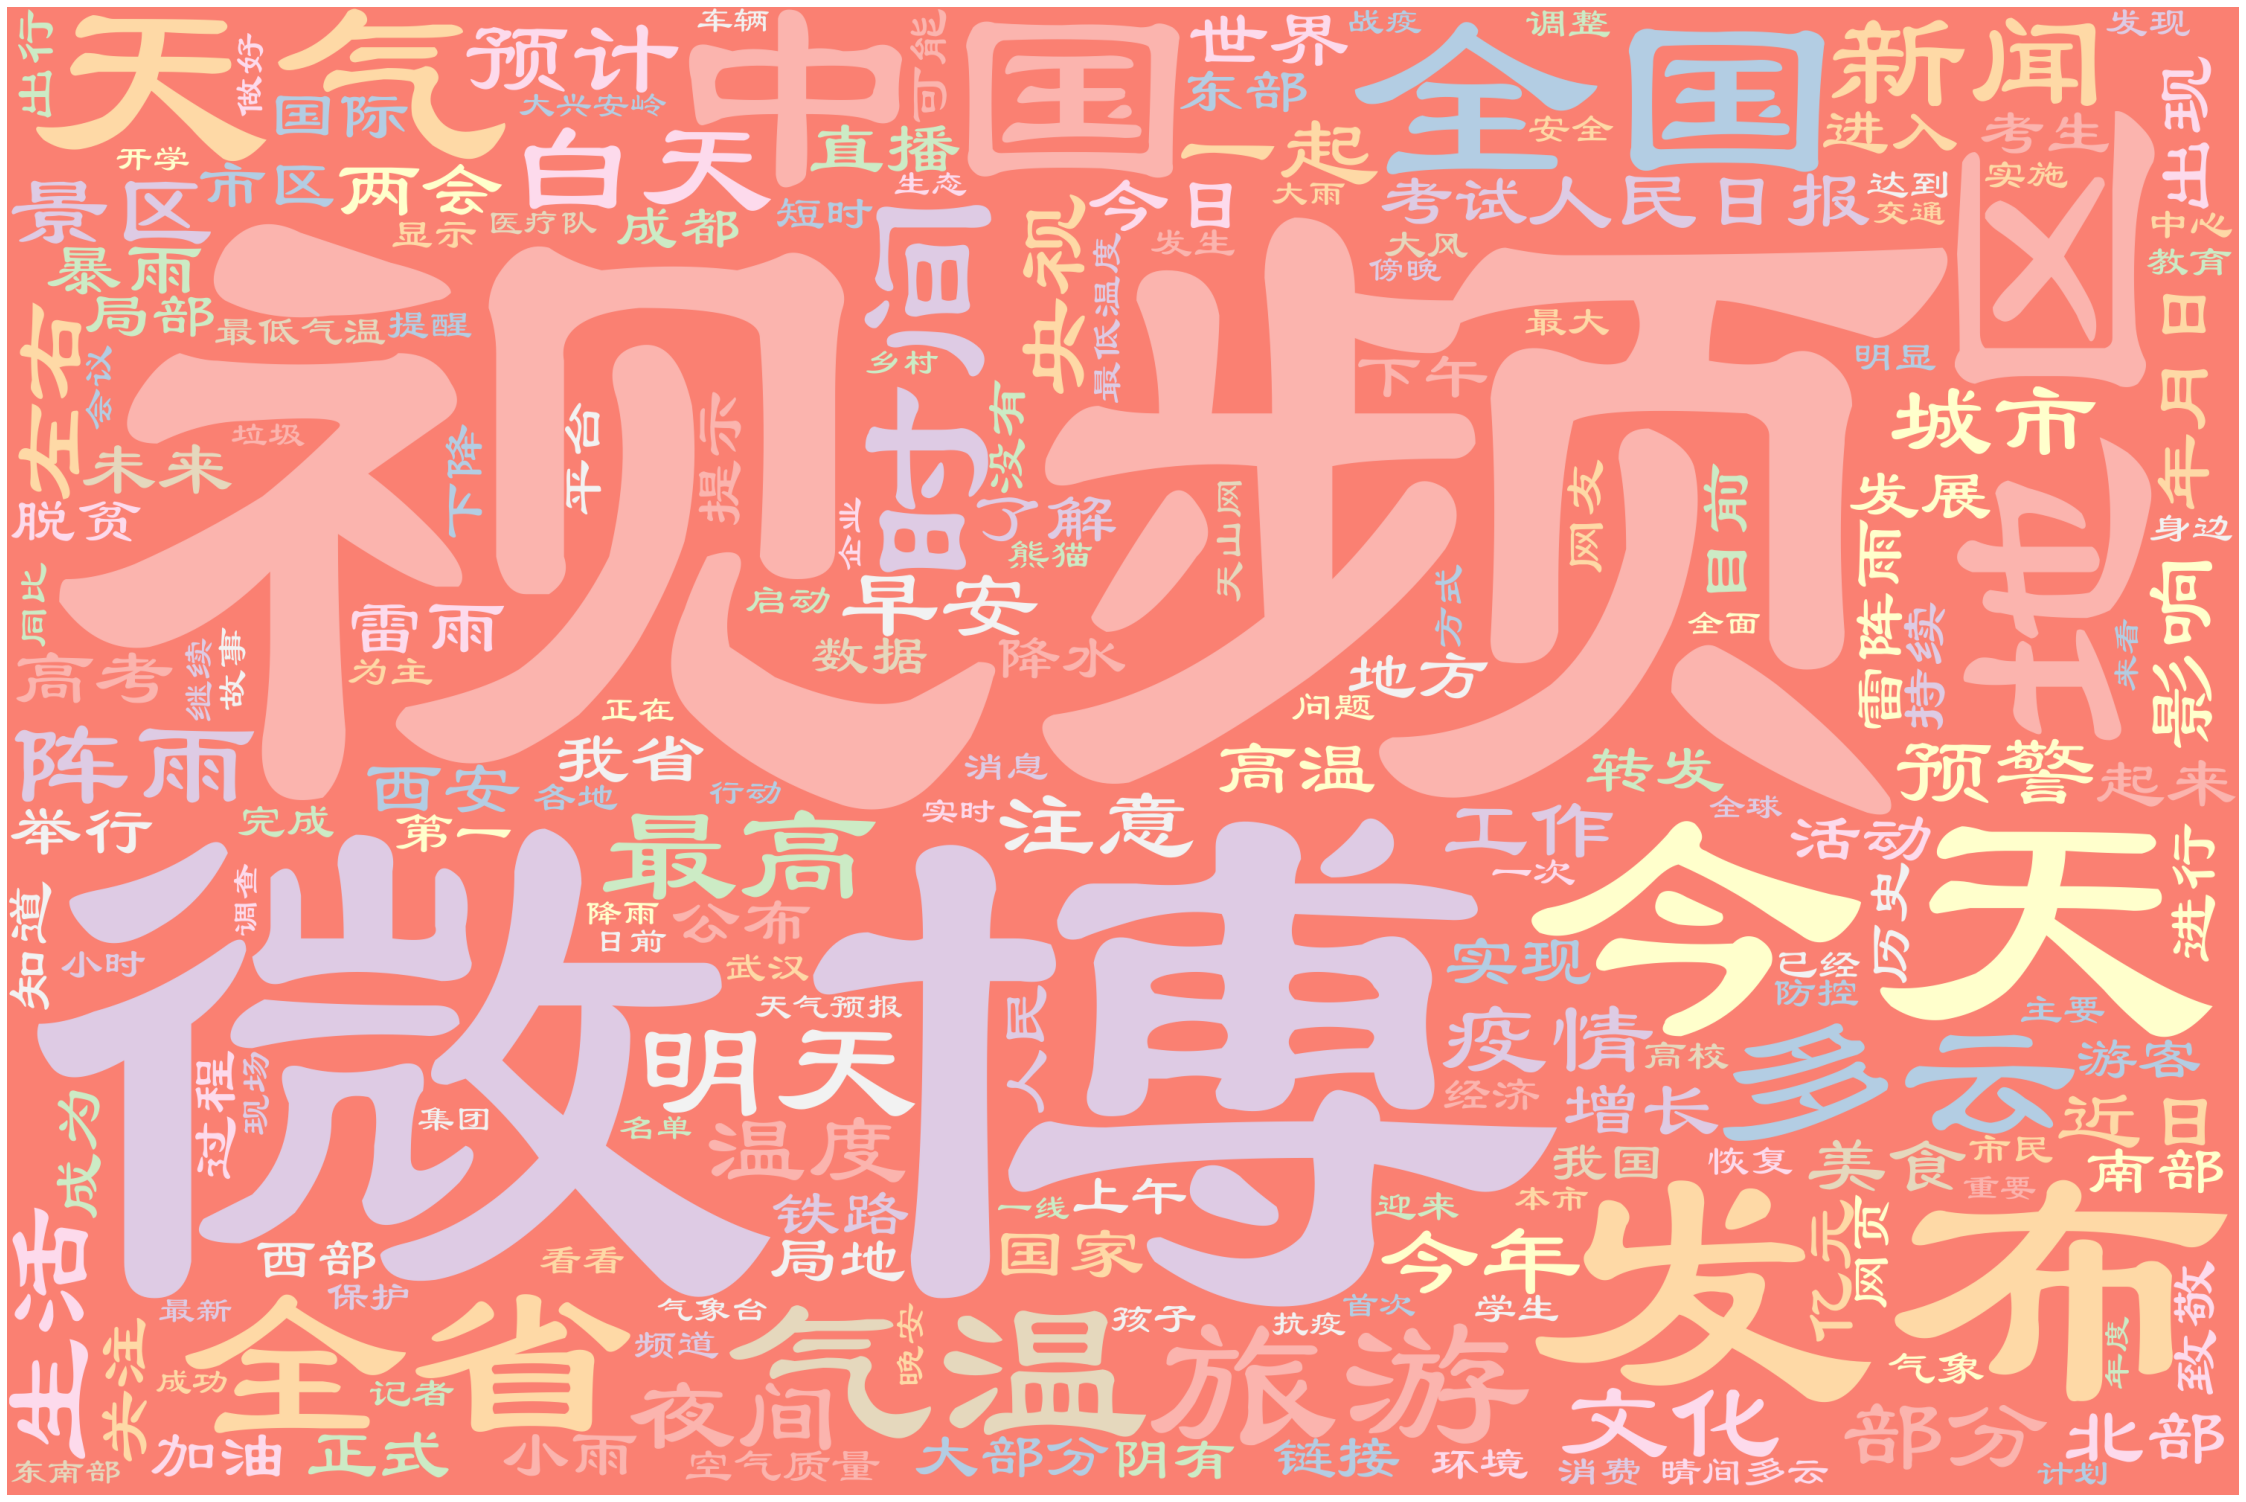

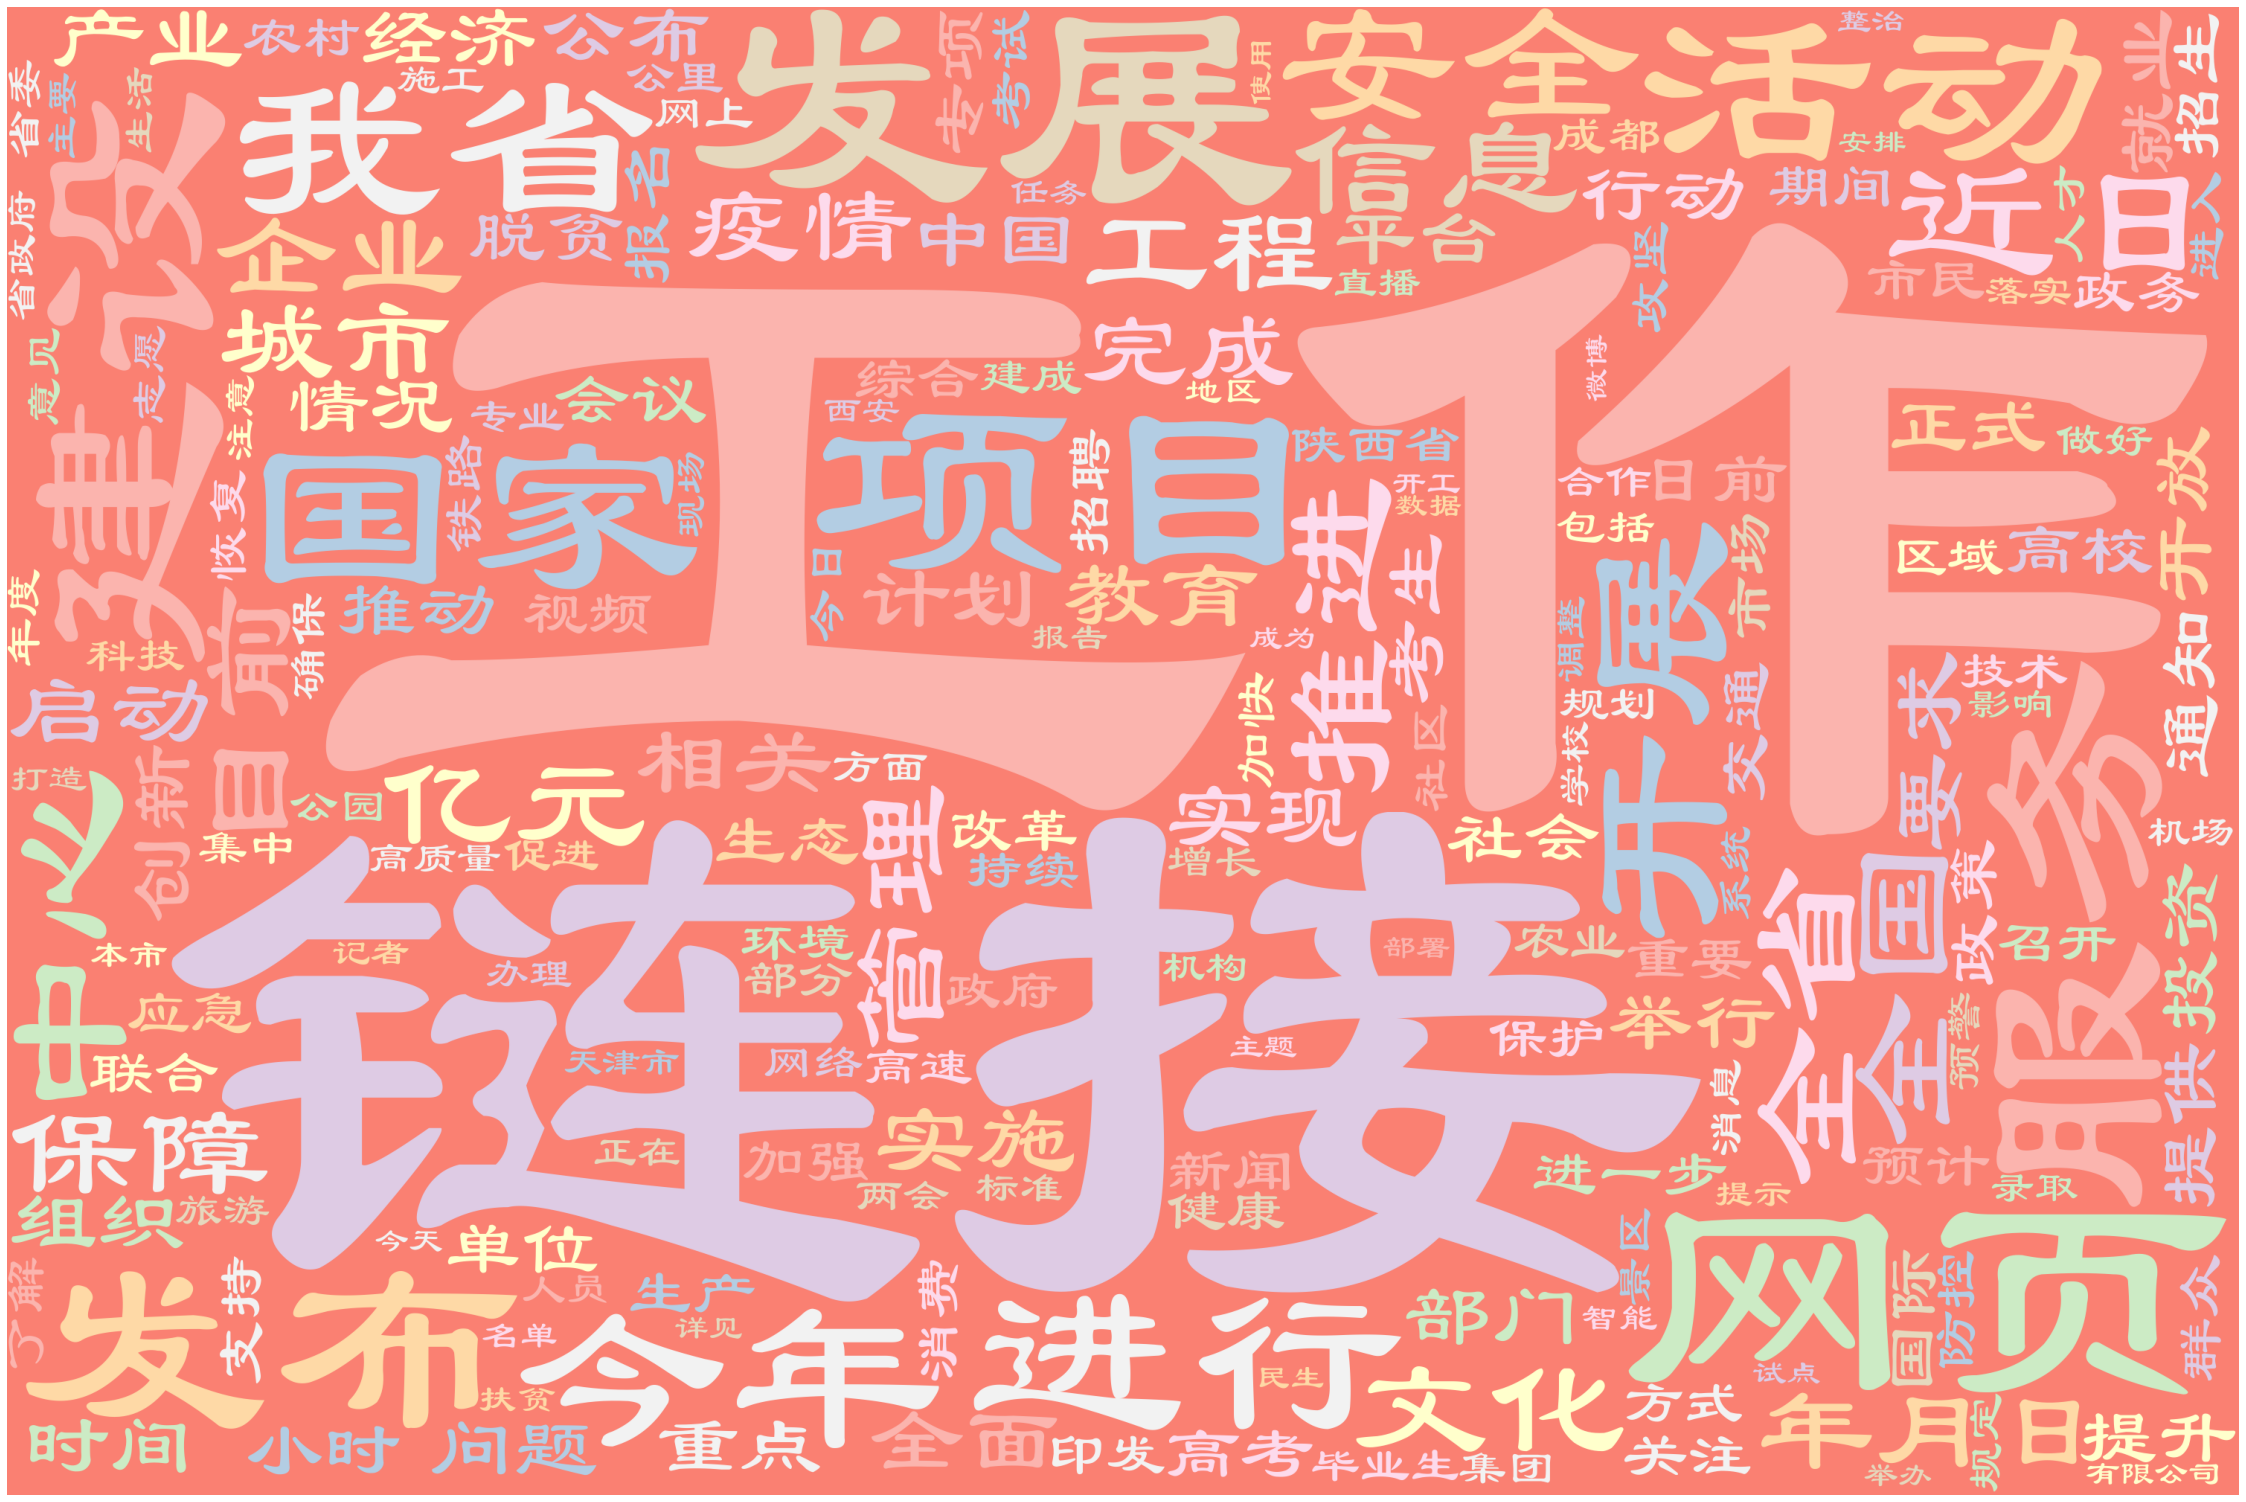

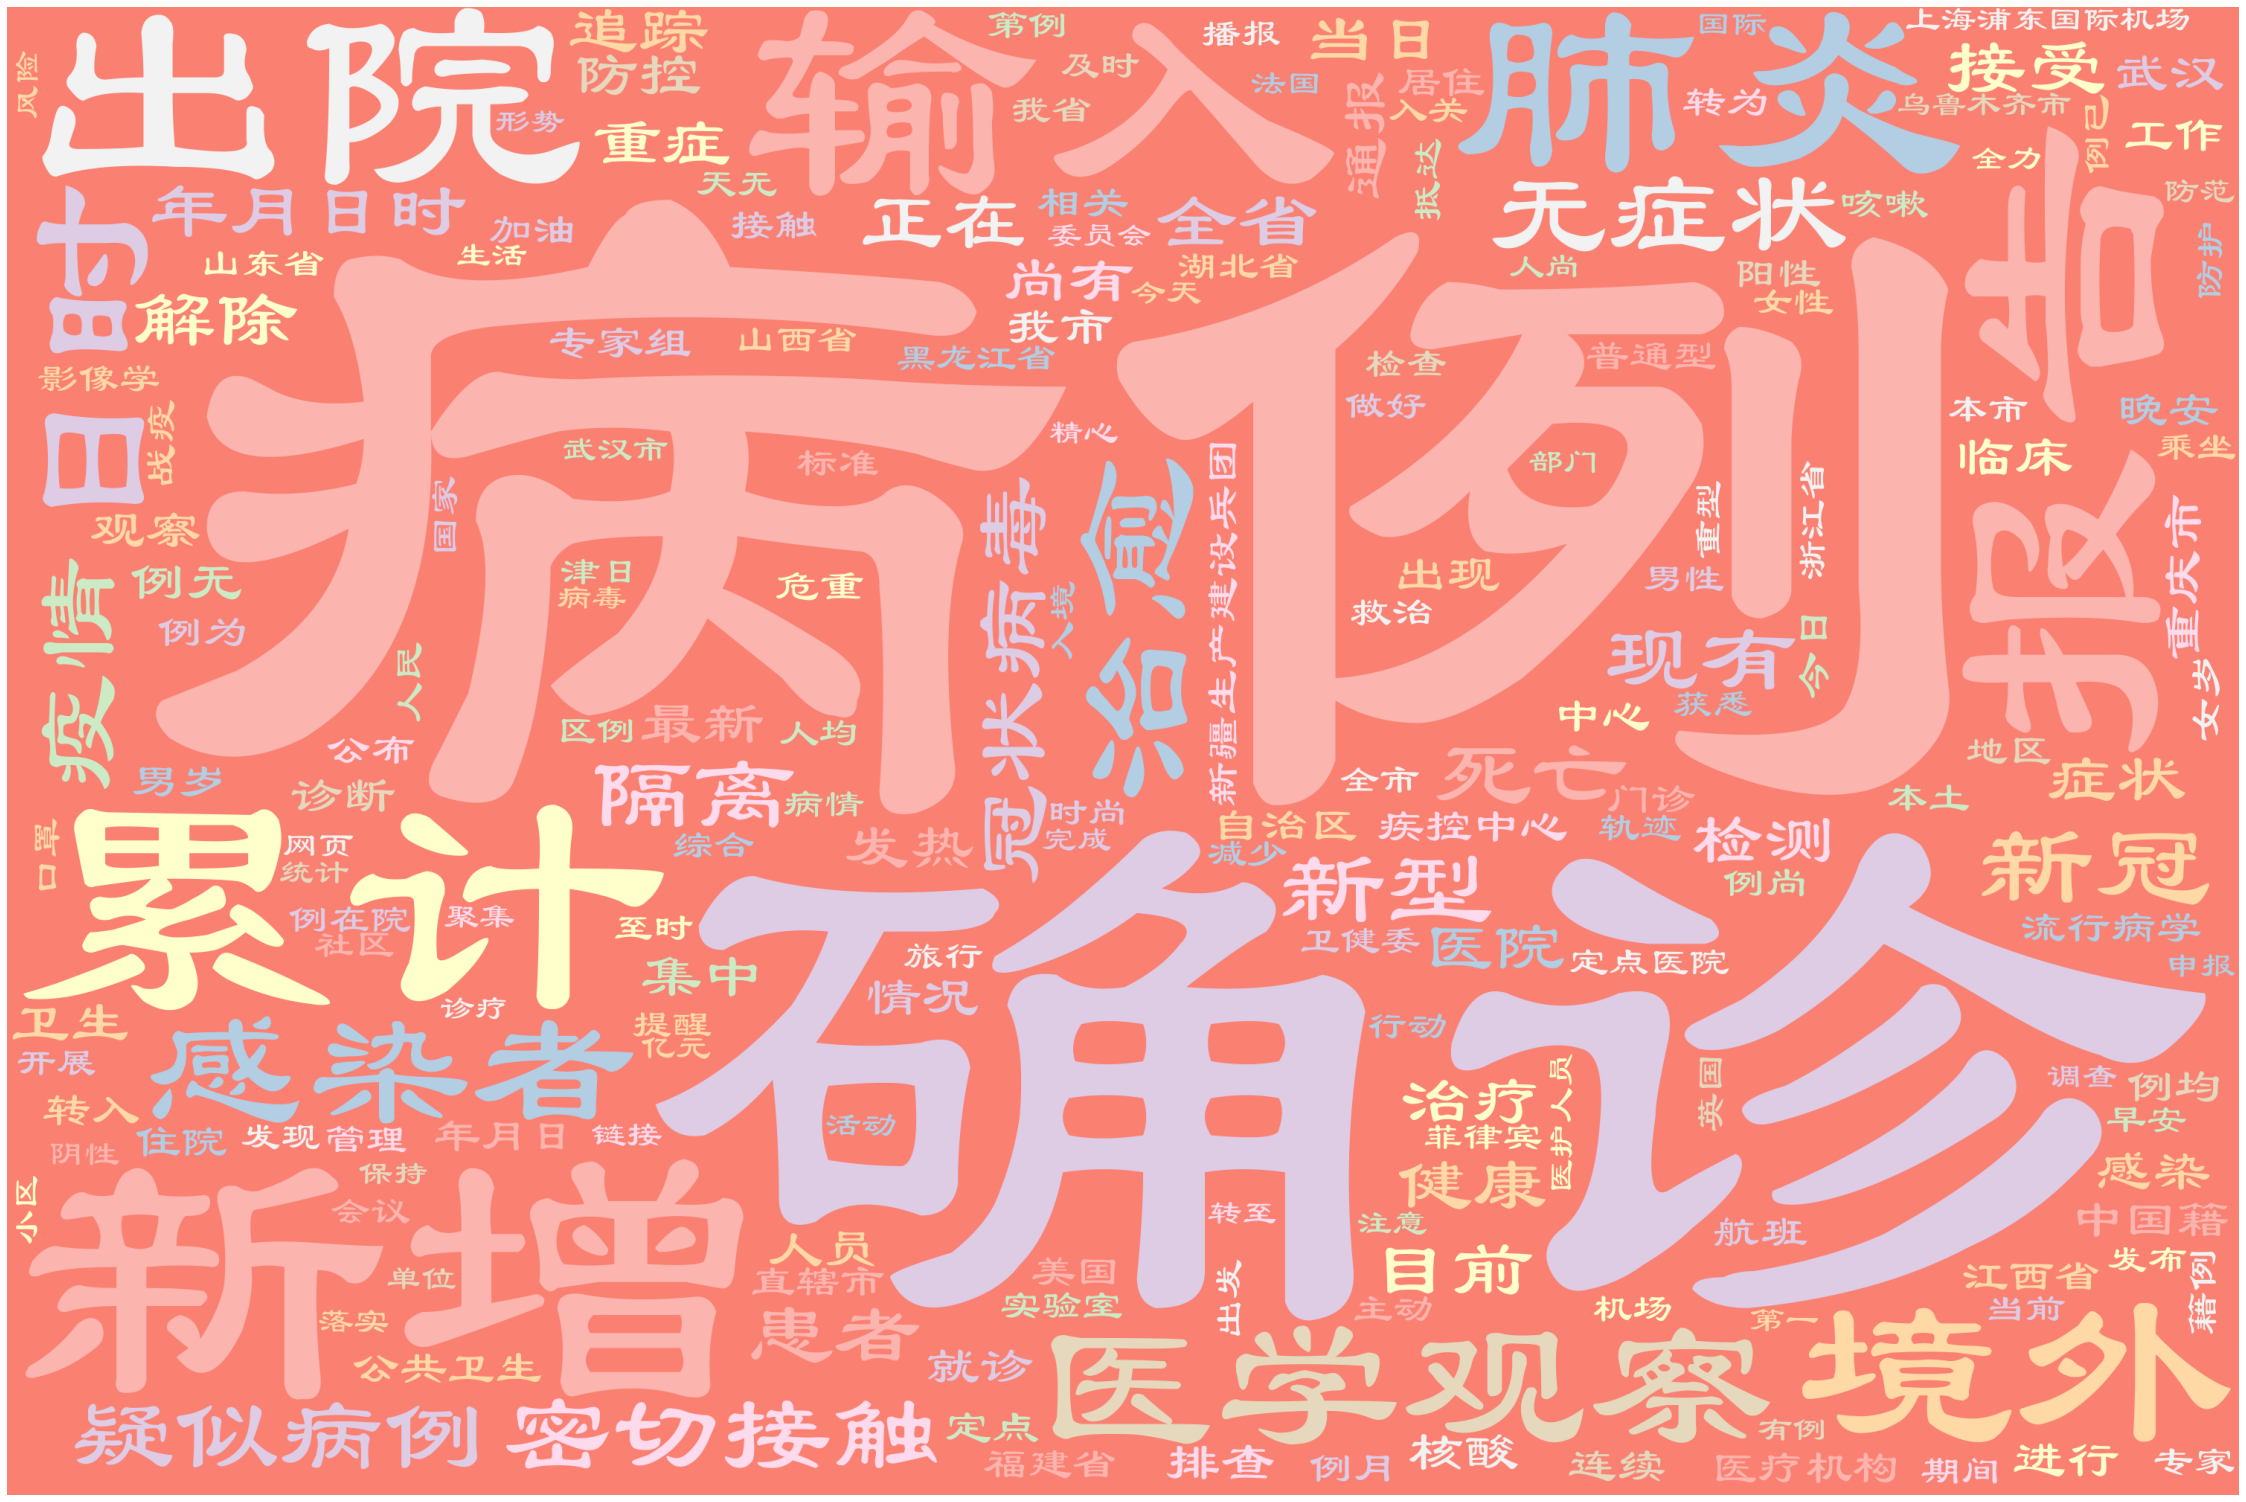

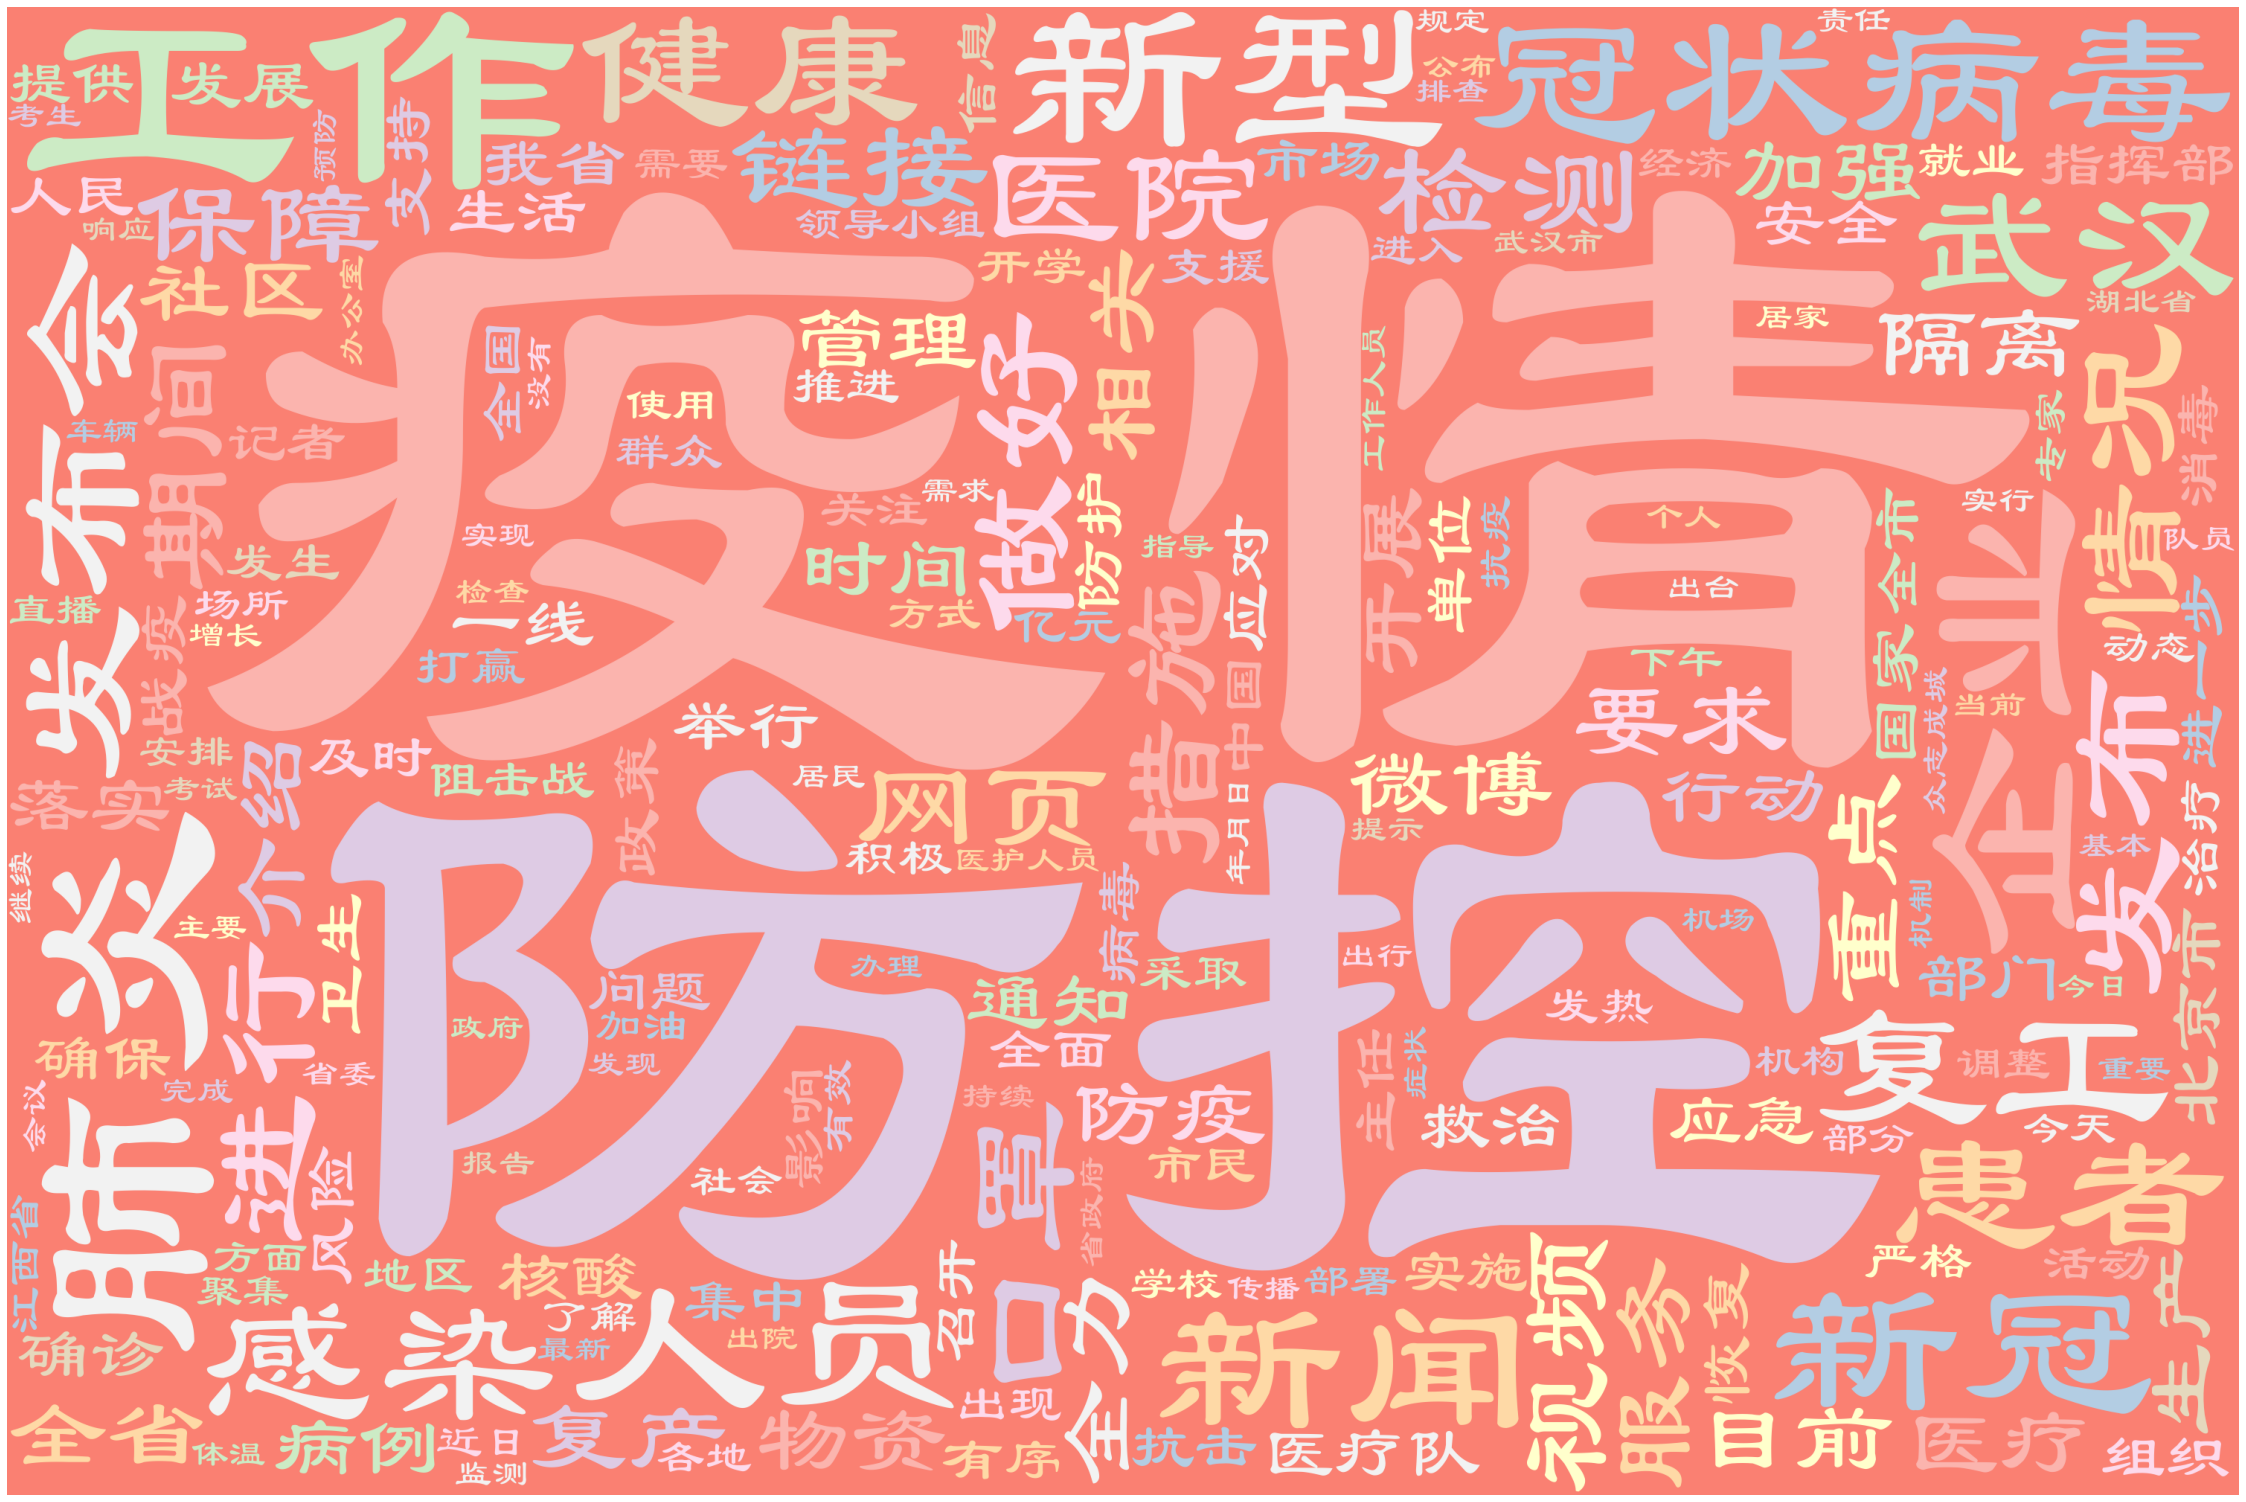

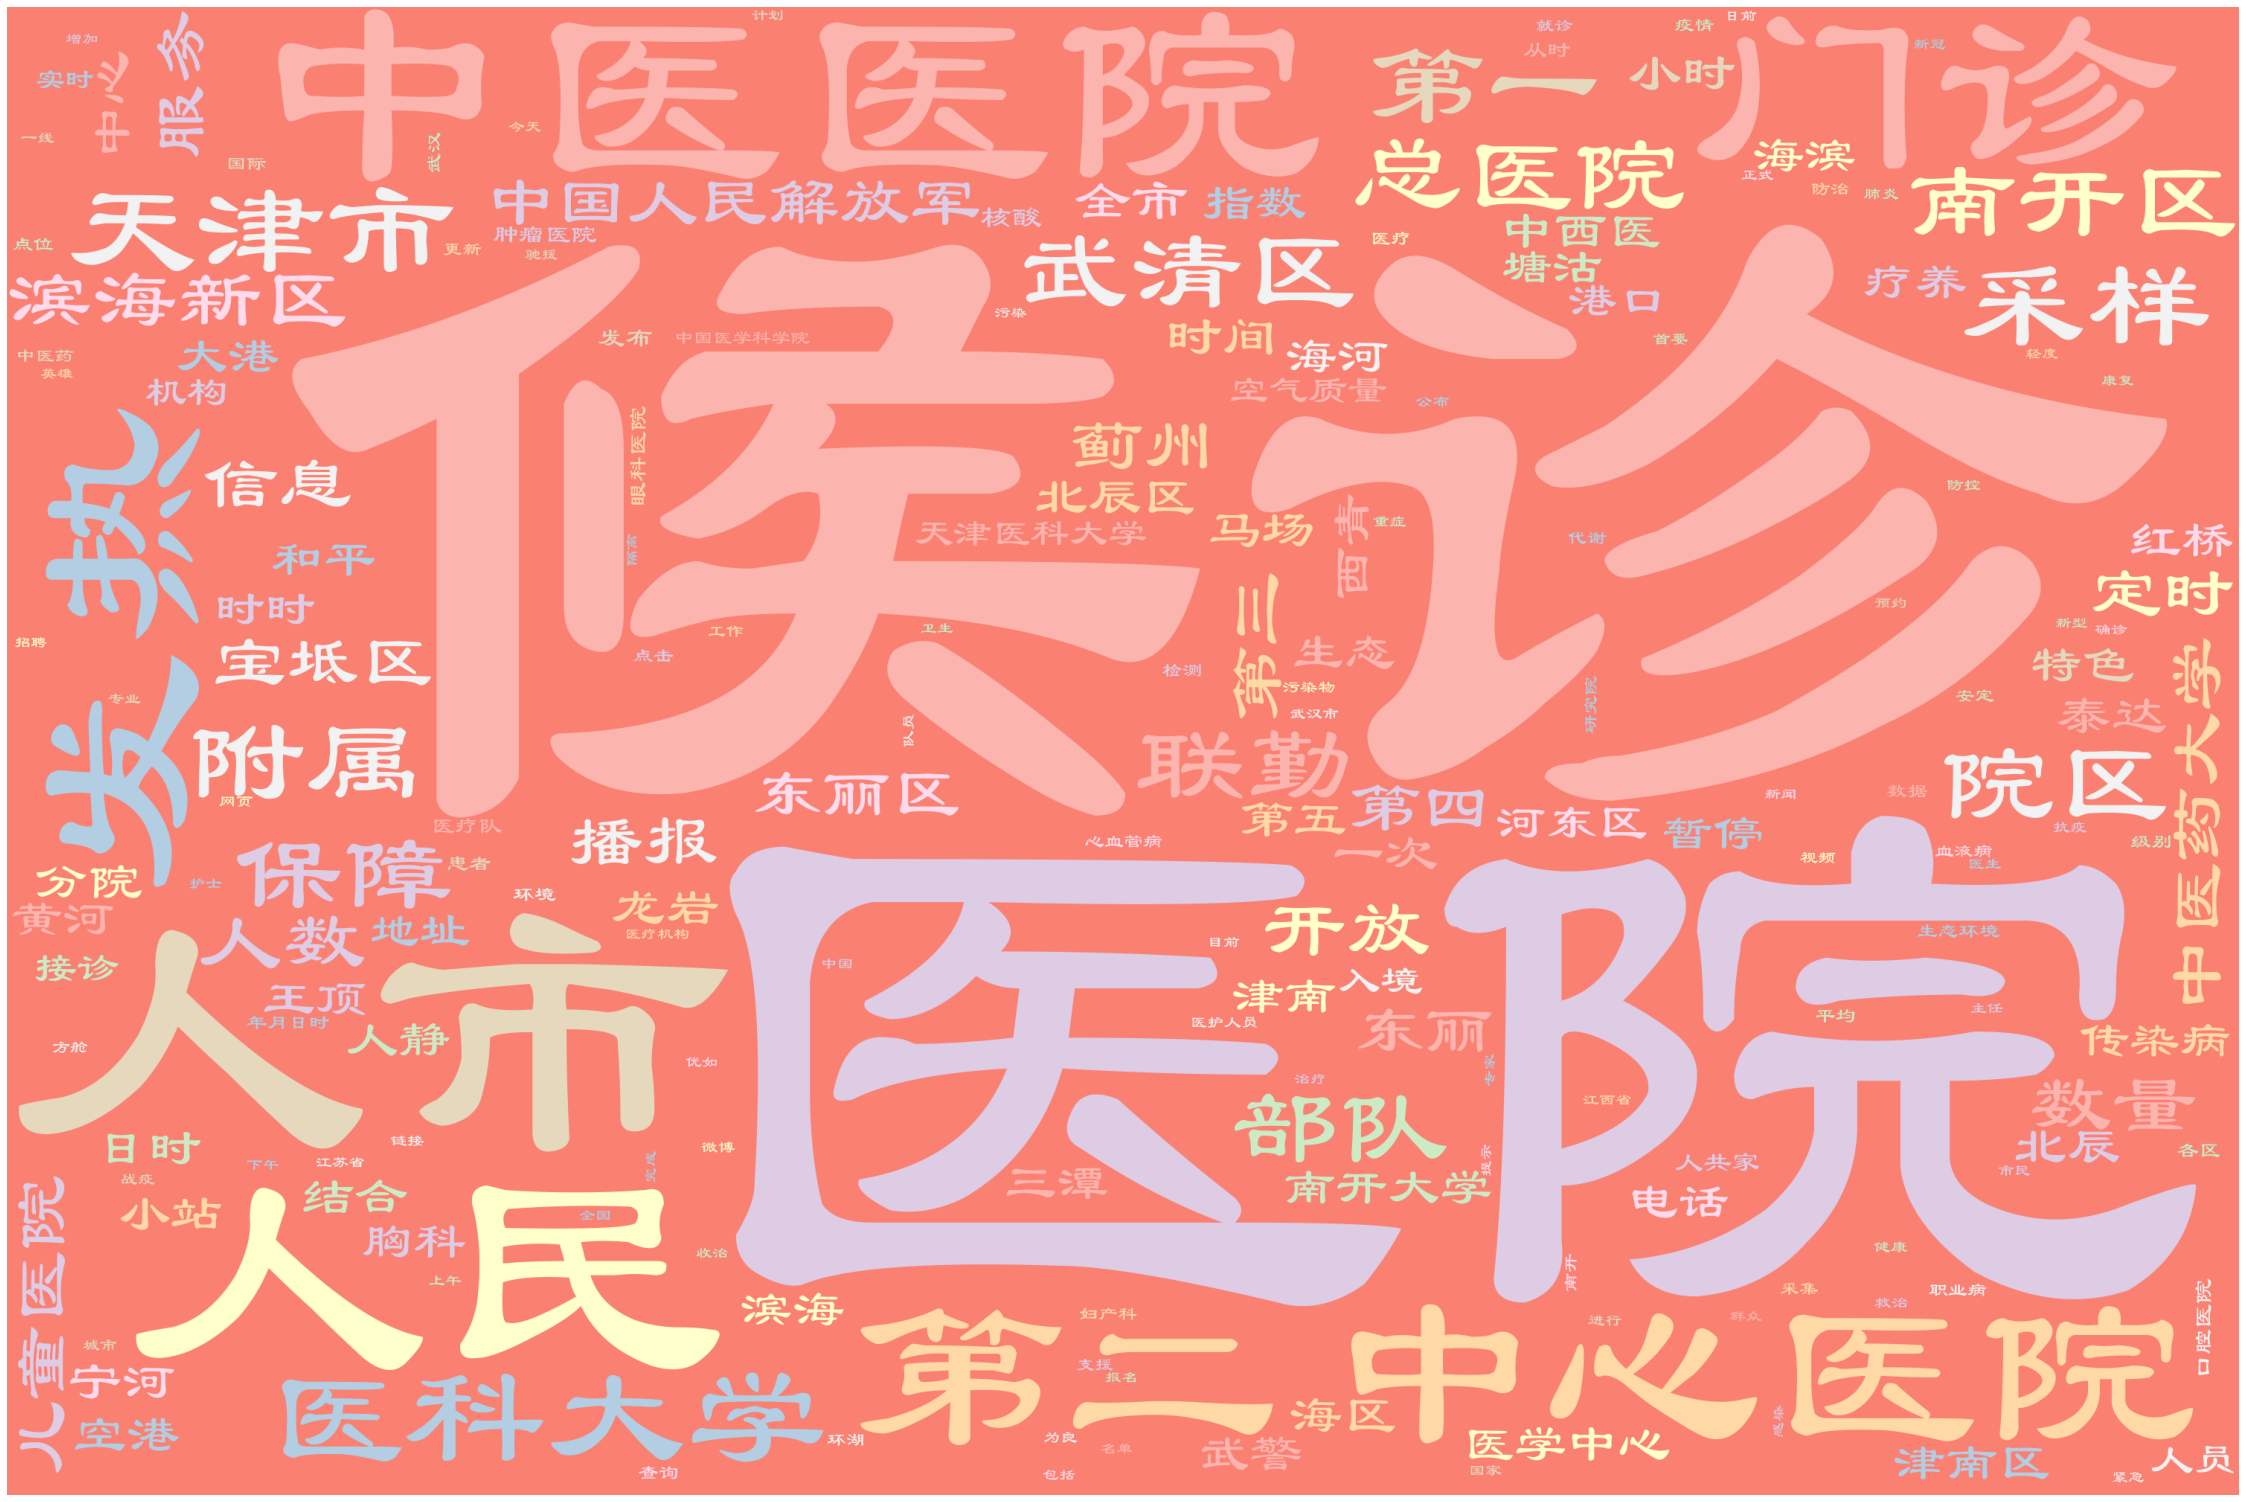

In [16]:
for i_topic in df['lda_topic'].unique():
    text = df[df['lda_topic'] == i_topic].content_re.tolist()
    cut_text = " ".join(jieba.cut(','.join(text)))
    wordcloud = WordCloud(width = 3000, 
                          height = 2000, 
                          random_state=1, 
                          font_path=font,
                          background_color='salmon', 
                          colormap='Pastel1', 
                          collocations=False, 
                          stopwords = stopwords(["zh"]) | set([w for w in corpus if len(w) == 1]) | set(['借傥', '唷', '啷']) | set(['北京','重庆','福建','广东','贵州','海南','黑龙江','河南','湖北','湖南','江苏','江西','吉林',
                                                                                                                                   '宁夏','青海','陕西','山东','上海','山西','四川','天津','新疆','浙江','湖北'])).generate(cut_text)
    # Plot
    plot_cloud(wordcloud)